<a href="https://colab.research.google.com/github/BerkayYuce/football-player-market-value-prediction-model/blob/main/Informer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1️⃣ Kütüphaneler

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import time
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


2️⃣ Informer Model Bileşenleri (Bu hücreyi aynen al)

In [ ]:
# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class ProbSparseAttention(nn.Module):

    def __init__(self, d_model, n_heads, factor=5, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.factor = factor
        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
    def _prob_QK(self, Q, K, sample_k, n_top):
        B, H, L_K, E = K.shape
        _, _, L_Q, _ = Q.shape
        K_expand = K.unsqueeze(-3).expand(B, H, L_Q, L_K, E)
        index_sample = torch.randint(L_K, (L_Q, sample_k))
        K_sample = K_expand[:, :, torch.arange(L_Q).unsqueeze(1), index_sample, :]
        Q_K_sample = torch.matmul(Q.unsqueeze(-2), K_sample.transpose(-2, -1)).squeeze(-2)
        M = Q_K_sample.max(-1)[0] - torch.div(Q_K_sample.sum(-1), L_K)
        M_top = M.topk(n_top, sorted=False)[1]
        Q_reduce = Q[torch.arange(B)[:, None, None],
                     torch.arange(H)[None, :, None],
                     M_top, :]
        Q_K = torch.matmul(Q_reduce, K.transpose(-2, -1))
        return Q_K, M_top
    def _get_initial_context(self, V, L_Q):
        B, H, L_V, D = V.shape
        if not self.training:
            V_sum = V.mean(dim=-2)
            contex = V_sum.unsqueeze(-2).expand(B, H, L_Q, V_sum.shape[-1]).clone()
        else:
            assert(L_Q == L_V)
            contex = V.cumsum(dim=-2)
        return contex
    def _update_context(self, context_in, V, scores, index, L_Q):
        B, H, L_V, D = V.shape
        if self.training:
            attn = torch.softmax(scores, dim=-1)
            context_in[torch.arange(B)[:, None, None],
                      torch.arange(H)[None, :, None],
                      index, :] = torch.matmul(attn, V).type_as(context_in)
            return (context_in, None)
        else:
            attn = torch.softmax(scores, dim=-1)
            context_in[torch.arange(B)[:, None, None],
                      torch.arange(H)[None, :, None],
                      index, :] = torch.matmul(attn, V).type_as(context_in)
            return (context_in, attn)
    def forward(self, queries, keys, values, attn_mask=None):
        B, L_Q, D = queries.shape
        B, L_K, D = keys.shape
        B, L_V, D = values.shape
        H = self.n_heads
        queries = self.w_q(queries).view(B, L_Q, H, -1).transpose(1, 2)
        keys = self.w_k(keys).view(B, L_K, H, -1).transpose(1, 2)
        values = self.w_v(values).view(B, L_V, H, -1).transpose(1, 2)
        U_part = self.factor * np.ceil(np.log(L_K)).astype('int').item()
        u = self.factor * np.ceil(np.log(L_Q)).astype('int').item()
        U_part = U_part if U_part < L_K else L_K
        u = u if u < L_Q else L_Q
        context = self._get_initial_context(values, L_Q)
        if u > 0:
            scores_top, index = self._prob_QK(queries, keys, sample_k=U_part, n_top=u)
            context, attn = self._update_context(context, values, scores_top, index, L_Q)
        out = context.transpose(1, 2).contiguous().view(B, L_Q, -1)
        return self.w_o(out), attn

class ConvLayer(nn.Module):
    def __init__(self, c_in):
        super().__init__()
        self.downConv = nn.Conv1d(in_channels=c_in, out_channels=c_in, kernel_size=3, padding=2, padding_mode='circular')
        self.norm = nn.BatchNorm1d(c_in)
        self.activation = nn.ELU()
        self.maxPool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
    def forward(self, x):
        x = self.downConv(x.permute(0, 2, 1))
        x = self.norm(x)
        x = self.activation(x)
        x = self.maxPool(x)
        x = x.transpose(1, 2)
        return x

class InformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff=None, dropout=0.1, activation='relu'):
        super().__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = ProbSparseAttention(d_model, n_heads, dropout=dropout)
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == 'relu' else F.gelu
    def forward(self, x, attn_mask=None):
        new_x, attn = self.attention(x, x, x, attn_mask=attn_mask)
        x = x + self.dropout(new_x)
        x = self.norm1(x)
        y = x
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        return self.norm2(x + y), attn

class InformerEncoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super().__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer
    def forward(self, x, attn_mask=None):
        attns = []
        if self.conv_layers is not None:
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x, attn_mask=attn_mask)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)
        if self.norm is not None:
            x = self.norm(x)
        return x, attns

class InformerModel(nn.Module):
    def __init__(self, seq_len, n_features, d_model=512, n_heads=8, e_layers=2,
                 d_ff=2048, dropout=0.05, activation='gelu', distil=True, output_attention=False):
        super().__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.d_model = d_model
        self.output_attention = output_attention
        self.enc_embedding = nn.Linear(n_features, d_model)
        self.position_encoding = PositionalEncoding(d_model)
        self.dropout = nn.Dropout(dropout)
        if distil:
            self.encoder = InformerEncoder(
                [InformerEncoderLayer(d_model, n_heads, d_ff, dropout, activation) for _ in range(e_layers)],
                [ConvLayer(d_model) for _ in range(e_layers - 1)] if e_layers > 1 else None,
                norm_layer=nn.LayerNorm(d_model)
            )
        else:
            self.encoder = InformerEncoder(
                [InformerEncoderLayer(d_model, n_heads, d_ff, dropout, activation) for _ in range(e_layers)],
                norm_layer=nn.LayerNorm(d_model)
            )
        self.projection = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)
        )
    def forward(self, x_enc, enc_self_mask=None):
        enc_out = self.enc_embedding(x_enc)
        enc_out = self.position_encoding(enc_out)
        enc_out = self.dropout(enc_out)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask)
        enc_out = enc_out.mean(dim=1)
        output = self.projection(enc_out).squeeze(-1)
        if self.output_attention:
            return output, attns
        else:
            return output


3️⃣ FootballDataset ve EarlyStopping

In [ ]:
class FootballDataset(Dataset):
    def __init__(self, X, y, seq_len=5, n_features=None):
        self.X = X
        self.y = y
        self.seq_len = seq_len
        self.n_features = n_features if n_features else X.shape[1] // seq_len
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x_seq = self.X[idx].reshape(self.seq_len, self.n_features)
        y_val = self.y[idx]
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"Early stopping at counter {self.counter}")
def safe_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100


4️⃣ Dosya Yükle, Feature Engineering, Scaler, Loader

In [ ]:
# Dosyaları yükle
train = pd.read_csv("train.csv")
val = pd.read_csv("val.csv")
test = pd.read_csv("test.csv")

target_col = "target"
id_cols = ["Oyuncu_ID", "Date"]
seq_len = 5

feature_cols = [col for col in train.columns if col not in [target_col] + id_cols]
feature_sets = [
    set([col.replace(f"_t{i}", "") for col in feature_cols if col.endswith(f"_t{i}")])
    for i in range(1, seq_len + 1)
]
common_features = set.intersection(*feature_sets)
print(f"Her sezon ortak feature sayısı: {len(common_features)}")

ordered_cols = []
for i in range(1, seq_len + 1):
    ordered_cols += [f"{feat}_t{i}" for feat in sorted(common_features)]

def prepare_X_y(df):
    X = df[ordered_cols].values
    y = df[target_col].values
    return X, y

X_train, y_train = prepare_X_y(train)
X_val, y_val = prepare_X_y(val)
X_test, y_test = prepare_X_y(test)

X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)
X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)
y_val = np.nan_to_num(y_val, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
y_test = np.nan_to_num(y_test, nan=0.0, posinf=0.0, neginf=0.0)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

dataset_train = FootballDataset(X_train_scaled, y_train_scaled, seq_len=seq_len, n_features=len(common_features))
dataset_val   = FootballDataset(X_val_scaled,   y_val_scaled,   seq_len=seq_len, n_features=len(common_features))
dataset_test  = FootballDataset(X_test_scaled,  y_test_scaled,  seq_len=seq_len, n_features=len(common_features))
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)


Her sezon ortak feature sayısı: 53


5️⃣ Model Kurulumu

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)
model = InformerModel(
    seq_len=seq_len,
    n_features=len(common_features),
    d_model=128,
    n_heads=8,
    e_layers=3,
    d_ff=256,
    dropout=0.3,
    activation='gelu',
    distil=True,
    output_attention=False
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
criterion = nn.MSELoss()


Device: cpu


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


6️⃣ Eğitim Döngüsü

In [ ]:
train_losses, val_losses = [], []
early_stopping = EarlyStopping(patience=15, min_delta=0.001)
start_train = time.time()
best_val_loss = float('inf')

for epoch in range(100):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)
    # Validation
    model.eval()
    total_val = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            total_val += loss.item()
    val_loss = total_val / len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    early_stopping(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_informer_model.pth')
    if epoch % 1 == 0 or epoch < 10:
        print(f"Epoch {epoch+1:3d} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | LR: {current_lr:.2e}")
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break
end_train = time.time()
train_time = end_train - start_train
model.load_state_dict(torch.load('best_informer_model.pth'))


Epoch   1 | Train: 0.7530 | Val: 0.5259 | LR: 1.00e-04
Epoch   2 | Train: 0.5081 | Val: 0.5314 | LR: 1.00e-04
Epoch   3 | Train: 0.4664 | Val: 0.4742 | LR: 1.00e-04
Epoch   4 | Train: 0.4154 | Val: 0.5104 | LR: 1.00e-04
Epoch   5 | Train: 0.3893 | Val: 0.5054 | LR: 1.00e-04
Epoch   6 | Train: 0.3681 | Val: 0.3462 | LR: 1.00e-04
Epoch   7 | Train: 0.3544 | Val: 0.3150 | LR: 1.00e-04
Epoch   8 | Train: 0.3392 | Val: 0.3111 | LR: 1.00e-04
Epoch   9 | Train: 0.3161 | Val: 0.3360 | LR: 1.00e-04
Epoch  10 | Train: 0.3272 | Val: 0.3676 | LR: 1.00e-04
Epoch  11 | Train: 0.2890 | Val: 0.2607 | LR: 1.00e-04
Epoch  12 | Train: 0.3303 | Val: 0.2395 | LR: 1.00e-04
Epoch  13 | Train: 0.2947 | Val: 0.2621 | LR: 1.00e-04
Epoch  14 | Train: 0.2905 | Val: 0.2598 | LR: 1.00e-04
Epoch  15 | Train: 0.2840 | Val: 0.2314 | LR: 1.00e-04
Epoch  16 | Train: 0.2644 | Val: 0.2627 | LR: 1.00e-04
Epoch  17 | Train: 0.2726 | Val: 0.2416 | LR: 1.00e-04
Epoch  18 | Train: 0.2595 | Val: 0.2596 | LR: 1.00e-04
Epoch  19 

<All keys matched successfully>

7️⃣ Test & Değerlendirme

In [ ]:
start_inf = time.time()
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(yb.numpy())
end_inf = time.time()
inf_time = end_inf - start_inf

y_true_inv = scaler_y.inverse_transform(np.array(y_true).reshape(-1,1)).flatten()
y_pred_inv = scaler_y.inverse_transform(np.array(y_pred).reshape(-1,1)).flatten()

mse = mean_squared_error(y_true_inv, y_pred_inv)
mae = mean_absolute_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_inv, y_pred_inv)
mape = safe_mape(y_true_inv, y_pred_inv)

print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Training Time: {train_time:.2f} seconds")
print(f"Inference Time: {inf_time:.4f} seconds")
print("="*50)



FINAL RESULTS
MSE: 107219823624192.00
MAE: 7194386.00
RMSE: 10354700.56
R²: 0.8121
MAPE: 50.65%
Training Time: 265.71 seconds
Inference Time: 0.1692 seconds


8️⃣ Grafikler

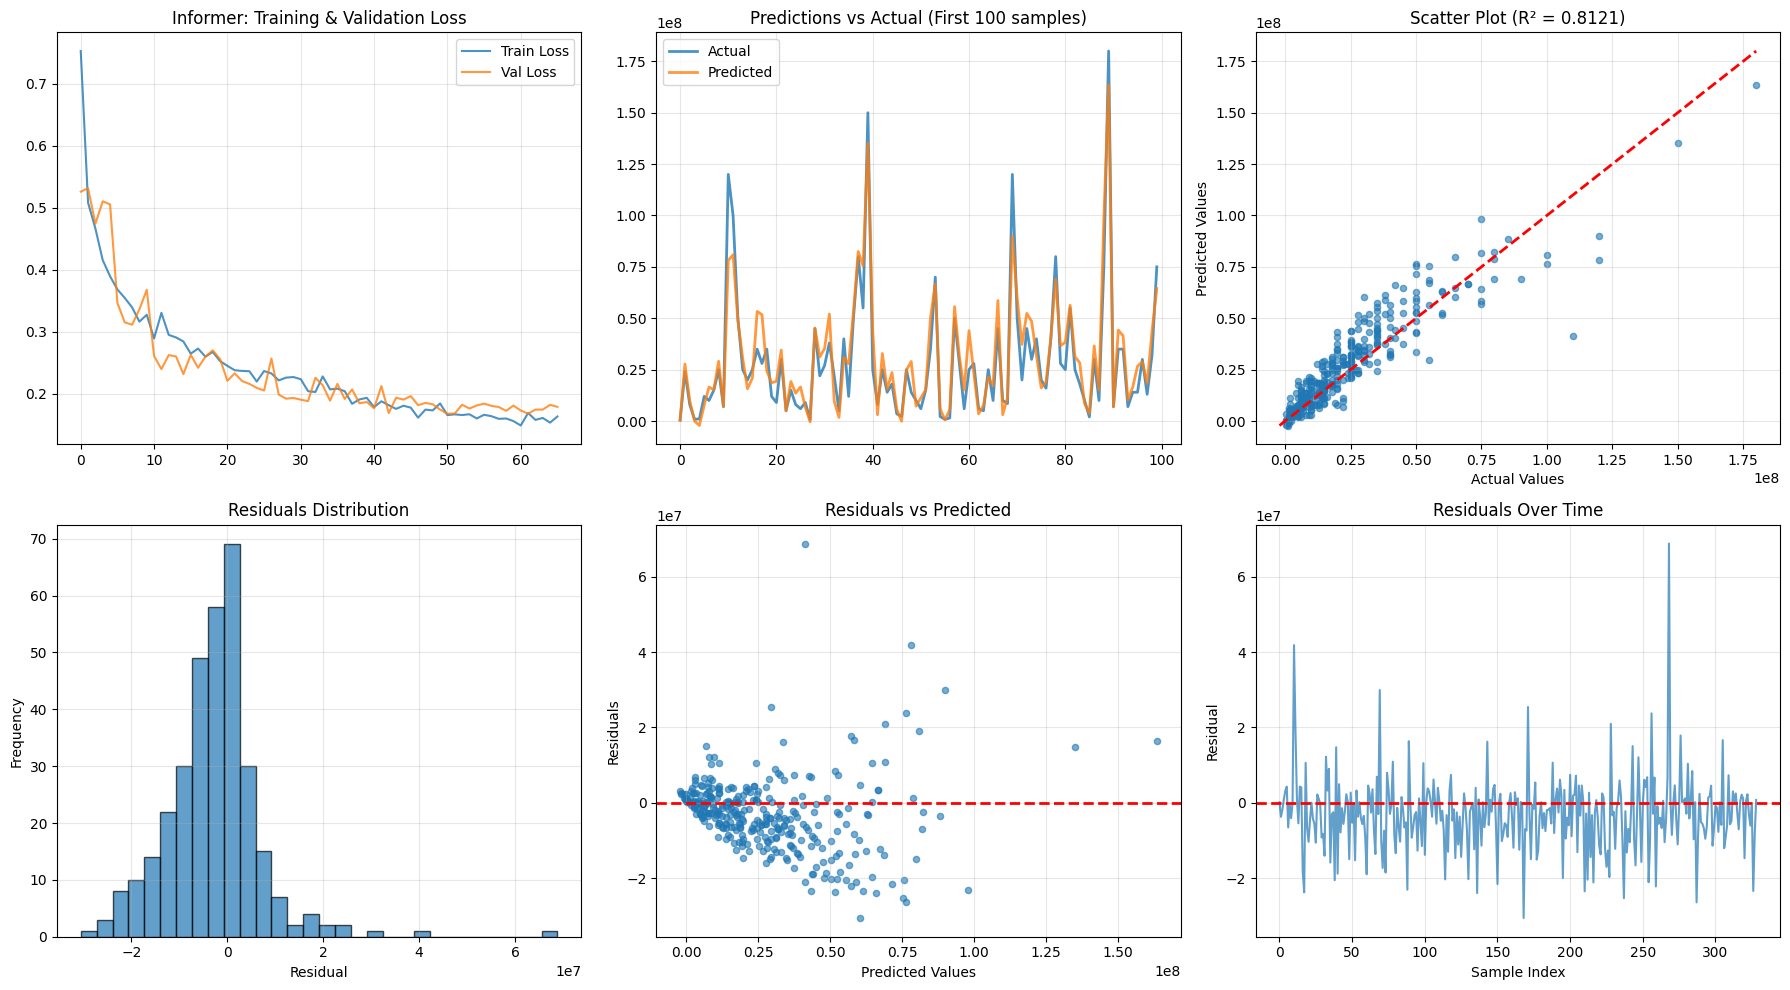

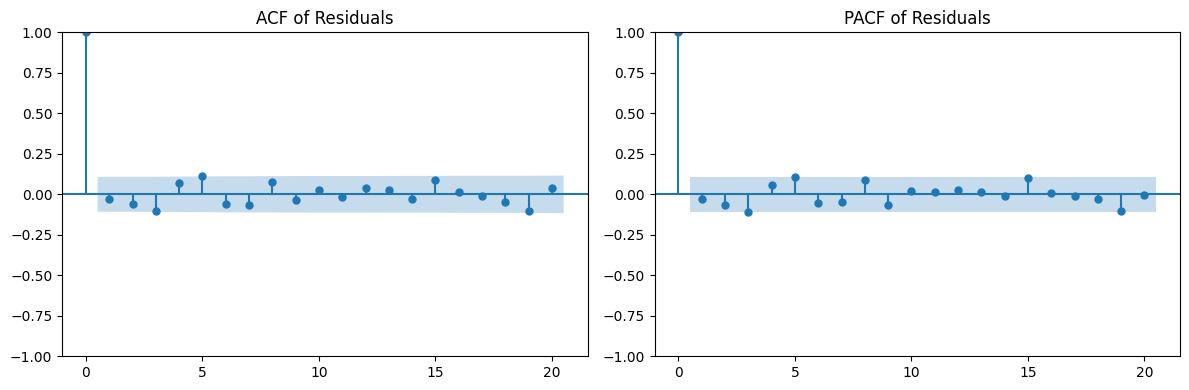

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes[0,0].plot(train_losses, label='Train Loss', alpha=0.8)
axes[0,0].plot(val_losses, label='Val Loss', alpha=0.8)
axes[0,0].set_title('Informer: Training & Validation Loss')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,1].plot(y_true_inv[:100], label='Actual', alpha=0.8, linewidth=2)
axes[0,1].plot(y_pred_inv[:100], label='Predicted', alpha=0.8, linewidth=2)
axes[0,1].set_title('Predictions vs Actual (First 100 samples)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)
axes[0,2].scatter(y_true_inv, y_pred_inv, alpha=0.6, s=20)
min_val, max_val = min(y_true_inv.min(), y_pred_inv.min()), max(y_true_inv.max(), y_pred_inv.max())
axes[0,2].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[0,2].set_xlabel('Actual Values')
axes[0,2].set_ylabel('Predicted Values')
axes[0,2].set_title(f'Scatter Plot (R² = {r2:.4f})')
axes[0,2].grid(True, alpha=0.3)
residuals = y_true_inv - y_pred_inv
axes[1,0].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
axes[1,0].set_title('Residuals Distribution')
axes[1,0].set_xlabel('Residual')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid(True, alpha=0.3)
axes[1,1].scatter(y_pred_inv, residuals, alpha=0.6, s=20)
axes[1,1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1,1].set_xlabel('Predicted Values')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Residuals vs Predicted')
axes[1,1].grid(True, alpha=0.3)
axes[1,2].plot(residuals, alpha=0.7)
axes[1,2].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1,2].set_title('Residuals Over Time')
axes[1,2].set_xlabel('Sample Index')
axes[1,2].set_ylabel('Residual')
axes[1,2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(residuals, lags=20, ax=ax1)
plot_pacf(residuals, lags=20, ax=ax2)
ax1.set_title("ACF of Residuals")
ax2.set_title("PACF of Residuals")
plt.tight_layout()
plt.show()
